# Overview

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Workflow 
1. Load Data
2. Data Wrangling
2. EDA
3. Modeling
4. Deployment

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Data Imputation
from sklearn.impute import KNNImputer

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer

# Modeling
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Validation
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Columns Definition
- PassengerId: Unique identifier for each passenger
- Survived: Survival status (0 = No, 1 = Yes)
- Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- Name: Passenger's name
- Sex: Gender
- Age: Age of the passenger
- SibSp: Number of siblings or spouses aboard the Titanic
- Parch: Number of parents or children aboard the Titanic
- Ticket: Ticket number
- Fare: Passenger fare
- Cabin: Cabin number
- Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
print(train_df.PassengerId.nunique())

891


In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [8]:
print(train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


**Remarks.**
- Needs to understand why a lot of age data is missing
- I think there's a correlation between fare and non-null value cabin, as the higher the fare amounts the more likely include the cabin

In [9]:
train_df.query("Age.isna()").describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,177.000000,177.000000,177.000000,0.0,177.000000,177.000000,177.000000
mean,435.581921,0.293785,2.598870,NaN,0.564972,0.180791,22.158567
std,250.552901,0.456787,0.763216,NaN,1.626316,0.534145,31.874608
min,6.000000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000
25%,230.000000,0.000000,3.000000,NaN,0.000000,0.000000,7.750000
50%,452.000000,0.000000,3.000000,NaN,0.000000,0.000000,8.050000
75%,634.000000,1.000000,3.000000,NaN,0.000000,0.000000,24.150000
max,889.000000,1.000000,3.000000,NaN,8.000000,2.000000,227.525000


In [10]:
train_df.query("~Age.isna()").describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,448.582633,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
std,259.119524,0.491460,0.838250,14.526497,0.929783,0.853289,52.918930
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.250000,0.000000,1.000000,20.125000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.741700
75%,677.750000,1.000000,3.000000,38.000000,1.000000,1.000000,33.375000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


- Create inputation model to predict the age based on  Pclass, Age, and Fare

## Data Wrangling

### Age Imputation

In [11]:
train_df_processed = train_df.copy()
test_df_processed = test_df.copy()

In [12]:
age_imputer = KNNImputer(n_neighbors=2)
age_imputer.fit(train_df_processed[['Pclass', 'Fare','SibSp', 'Parch', 'Age']])

train_df_processed['Age'] = age_imputer.transform(train_df_processed[['Pclass', 'Fare','SibSp', 'Parch', 'Age']])[:, -1]
test_df_processed['Age'] = age_imputer.transform(test_df_processed[['Pclass', 'Fare','SibSp', 'Parch', 'Age']])[:, -1]

### Fare Imputation

In [13]:
train_df_processed['Fare'] = train_df_processed.Fare.fillna(train_df_processed.Fare.median())
test_df_processed['Fare'] = test_df_processed.Fare.fillna(test_df_processed.Fare.median())

### Cabin Feature

In [14]:
train_df_processed['has_cabin'] = ~train_df_processed.Cabin.isna() * 1
test_df_processed['has_cabin'] = ~test_df_processed.Cabin.isna() * 1

In [15]:
train_df_processed['cabin_type'] = train_df_processed.Cabin.fillna("-").apply(lambda x: x[0])
test_df_processed['cabin_type'] = test_df_processed.Cabin.fillna("-").apply(lambda x: x[0])

### Ticket Feature

In [16]:
train_df_processed['ticket_type'] = train_df_processed.Ticket.apply(lambda x: x[:3])
test_df_processed['ticket_type'] = test_df_processed.Ticket.apply(lambda x: x[:3])

### Title Feature

In [17]:
train_df_processed['Title'] = train_df_processed.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
test_df_processed['Title'] = test_df_processed.Name.str.split(',').str[1].str.split('.').str[0].str.strip()

In [18]:
train_df_processed.Title.value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [19]:
test_df_processed.Title.value_counts()

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [20]:
train_df_processed['Title'] = train_df_processed.Title.apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Other')
test_df_processed['Title'] = test_df_processed.Title.apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Other')

In [21]:
train_df_processed[["Title", "Survived"]].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.792000
1,Miss,0.697802
0,Master,0.575000
4,Other,0.444444
2,Mr,0.156673


### Embarked Imputation

In [22]:
train_df_processed.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [23]:
train_df_processed.Embarked.fillna('S', inplace=True)
test_df_processed.Embarked.fillna('S', inplace=True)

In [24]:
train_df_processed

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin,cabin_type,ticket_type,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,-,A/5,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,C,PC,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,-,STO,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,C,113,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,-,373,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,-,211,Other
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,B,112,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,33.0,1,2,W./C. 6607,23.4500,NaN,S,0,-,W./,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1,C,111,Mr


### Sex Encoding

In [25]:
train_df_processed['Sex_en'] = train_df_processed.Sex.map({'male':0, 'female':1})
test_df_processed['Sex_en'] = test_df_processed.Sex.map({'male':0, 'female':1})

### Number of family Feature

In [26]:
train_df_processed['family_number'] = train_df_processed.eval("SibSp + Parch")
test_df_processed['family_number'] = test_df_processed.eval("SibSp + Parch")

### Alone Traveling Feature

In [27]:
train_df_processed['is_alone'] = train_df_processed.eval("family_number < 1") * 1
test_df_processed['is_alone'] = test_df_processed.eval("family_number < 1") * 1

## Visualization

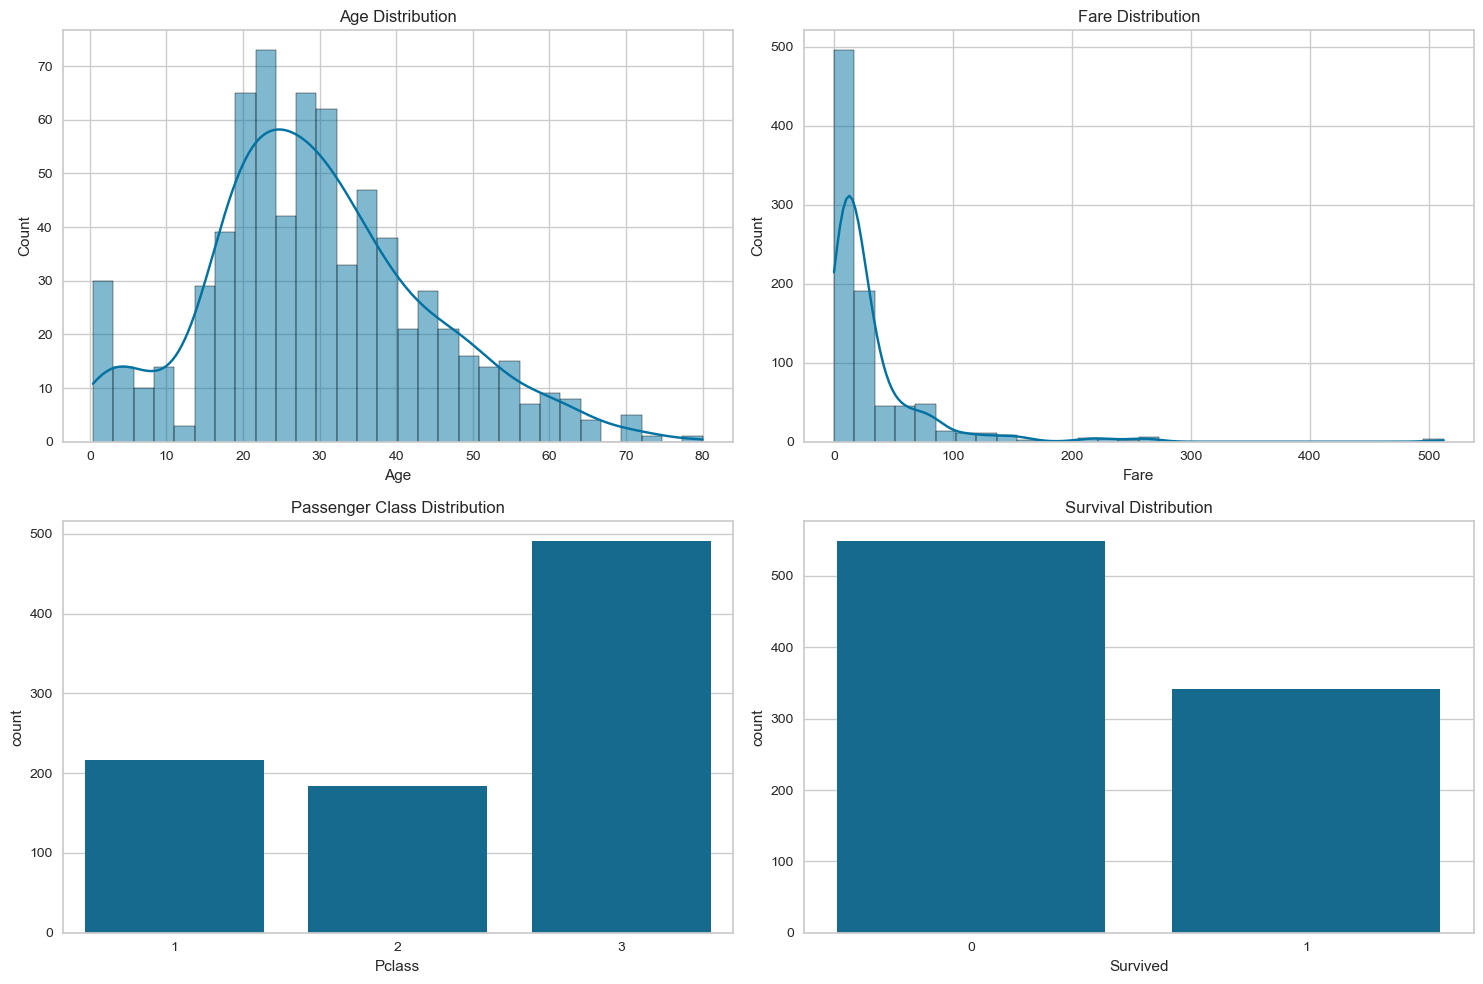

In [28]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot the distribution of Age
plt.subplot(2, 2, 1)
sns.histplot(train_df['Age'].dropna(), kde=True, bins=30)
plt.title('Age Distribution')

# Plot the distribution of Fare
plt.subplot(2, 2, 2)
sns.histplot(train_df['Fare'], kde=True, bins=30)
plt.title('Fare Distribution')

# Plot the count of passengers by class
plt.subplot(2, 2, 3)
sns.countplot(x='Pclass', data=train_df)
plt.title('Passenger Class Distribution')

# Plot the count of survivors
plt.subplot(2, 2, 4)
sns.countplot(x='Survived', data=train_df)
plt.title('Survival Distribution')

plt.tight_layout()
plt.show()


In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<Axes: >

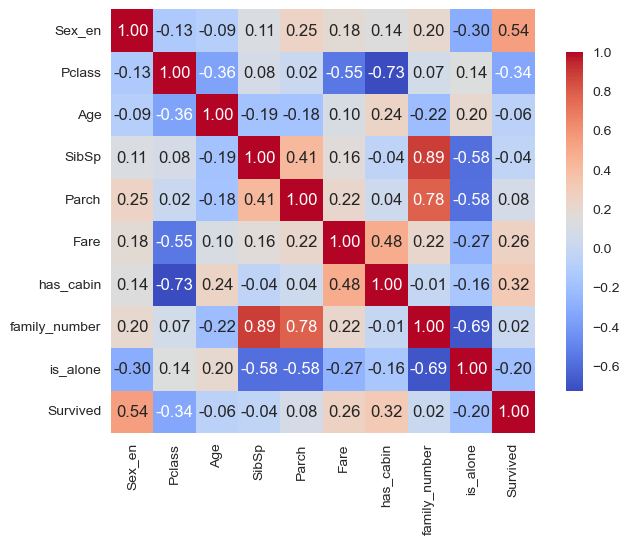

In [30]:
corr = train_df_processed[['Sex_en', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'has_cabin', 'family_number', 'is_alone', 'Survived']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})

## Pivot Analysis

In [31]:
train_df_processed[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [32]:
train_df_processed[['has_cabin', 'Survived']].groupby(['has_cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,has_cabin,Survived
1,1,0.666667
0,0,0.299854


In [33]:
train_df_processed[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [34]:
train_df_processed[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.792000
1,Miss,0.697802
0,Master,0.575000
4,Other,0.444444
2,Mr,0.156673


In [35]:
train_df_processed[['is_alone', 'Survived']].groupby(['is_alone'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,is_alone,Survived
0,0,0.505650
1,1,0.303538


# Cluster Analysis

In [36]:
feature_list = ['Sex_en', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'has_cabin']
features = train_df_processed[feature_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### KMEeans

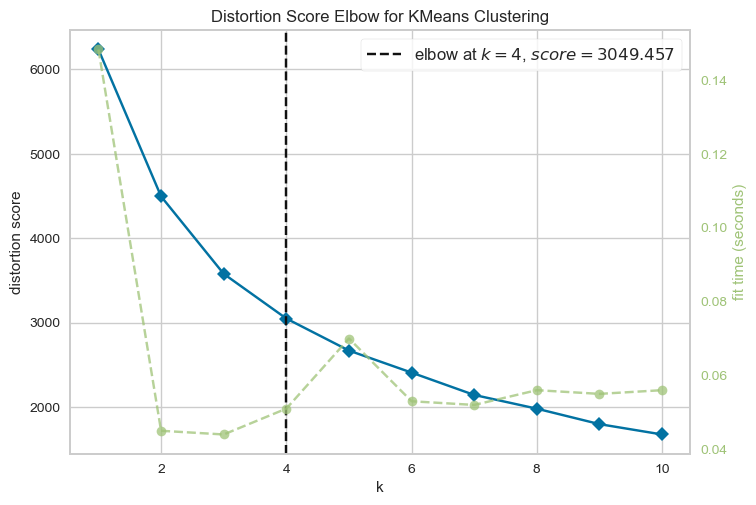

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [37]:
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(scaled_features)        # Fit the data to the visualizer
visualizer.show()

In [38]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)

KMeans(n_clusters=4, random_state=42)

In [39]:
features['kmeans_label'] = kmeans.predict(scaled_features)

### DBSCSAN

In [40]:
dbscan = DBSCAN(eps=0.1)
dbscan.fit(scaled_features)

features['dbscan_label'] = dbscan.labels_
features['dbscan_label'] = features.dbscan_label.apply(lambda x: 100 if x < 0 else x)
features['Survived'] = train_df_processed['Survived']

In [41]:
features.columns

Index(['Sex_en', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'has_cabin',
       'kmeans_label', 'dbscan_label', 'Survived'],
      dtype='object')

In [42]:
features.groupby('dbscan_label').mean()

,Sex_en,Pclass,Age,SibSp,Parch,Fare,has_cabin,kmeans_label,Survived
dbscan_label,,,,,,,,,
0,1.000000,3.0000,23.810000,0.000000,0.000000,8.041008,0.000000,1.000000,0.560000
1,0.000000,3.0000,25.244737,0.000000,0.000000,8.097582,0.000000,0.000000,0.105263
2,1.000000,3.0000,15.200000,0.000000,0.000000,7.718340,0.000000,1.000000,0.800000
3,0.000000,3.0000,42.500000,0.000000,0.000000,7.637082,0.000000,0.000000,0.100000
4,1.000000,3.0000,46.111111,0.000000,0.000000,7.750000,0.000000,1.000000,0.777778
5,1.000000,3.0000,18.285714,0.000000,0.000000,7.887500,0.000000,1.000000,0.714286
6,0.000000,2.0000,26.875000,0.000000,0.000000,12.272742,0.000000,0.000000,0.041667
7,0.000000,2.0000,18.500000,0.000000,0.000000,11.666667,0.000000,0.000000,0.166667
8,0.000000,2.0000,34.531250,0.000000,0.000000,12.540625,0.000000,0.000000,0.125000


## PCA

In [43]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['Survived'] = train_df_processed['Survived']
principal_df['dbscan_label'] = features['dbscan_label']
principal_df['kmeans_label'] = features['kmeans_label']

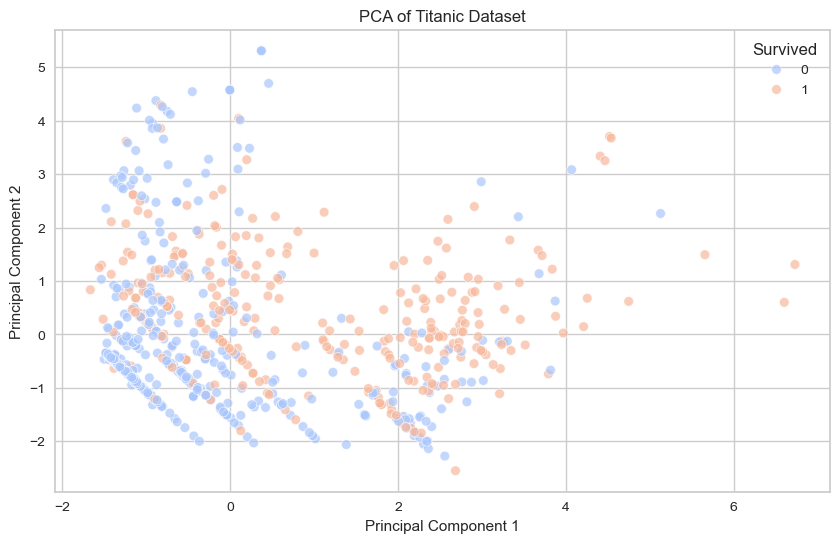

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='Survived', palette='coolwarm', alpha=0.7)
plt.title('PCA of Titanic Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Survived')
plt.show()

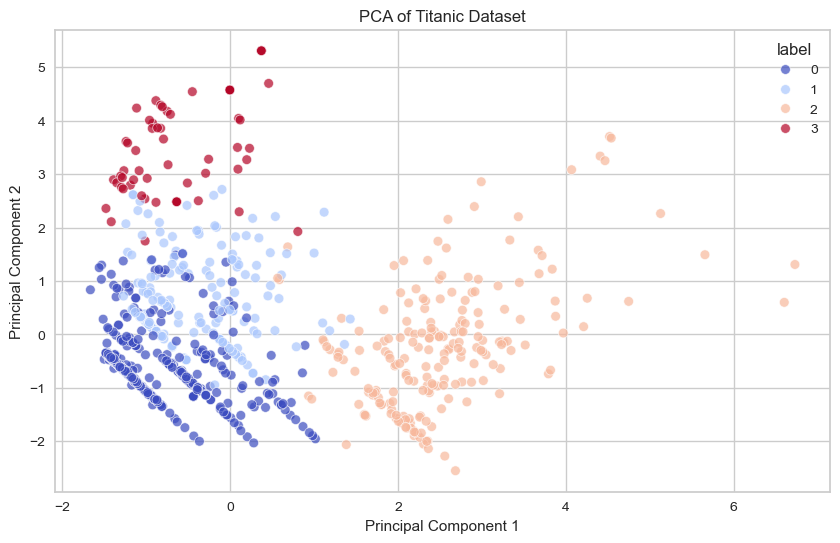

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='kmeans_label', palette='coolwarm', alpha=0.7)
plt.title('PCA of Titanic Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='label')
plt.show()

In [46]:
features.groupby('kmeans_label').mean()

,Sex_en,Pclass,Age,SibSp,Parch,Fare,has_cabin,dbscan_label,Survived
kmeans_label,,,,,,,,,
0,0.000000,2.670429,30.038375,0.207675,0.103837,13.471724,0.013544,39.534989,0.142212
1,1.000000,2.598930,25.875455,0.438503,0.454545,17.328232,0.037433,70.566845,0.716578
2,0.480392,1.073529,37.823137,0.441176,0.401961,85.430414,0.936275,100.000000,0.676471
3,0.508772,2.964912,20.289474,3.543860,2.228070,36.101611,0.000000,100.000000,0.122807


In [47]:
features.kmeans_label.value_counts()

kmeans_label
0    443
2    204
1    187
3     57
Name: count, dtype: int64

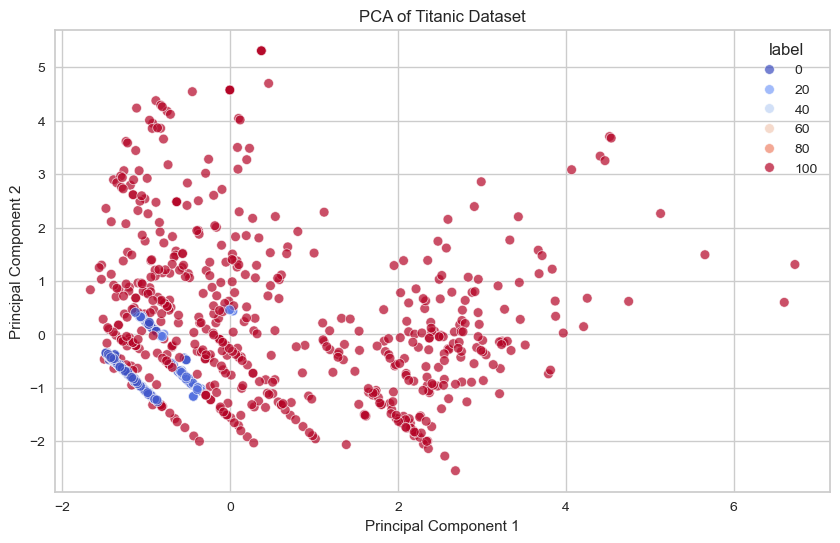

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='dbscan_label', palette='coolwarm', alpha=0.7)
plt.title('PCA of Titanic Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='label')
plt.show()

## Adding kmeans label to features

In [49]:
train_df_processed['kmeans_label'] = kmeans.predict(train_df_processed[feature_list])
test_df_processed['kmeans_label'] = kmeans.predict(test_df_processed[feature_list])

# Modeling

## Preprocessing

In [50]:
X = train_df_processed.drop(['PassengerId', 'Survived', 'Ticket', 'Cabin', 'Name', 'Sex'], axis=1)
y = train_df_processed.Survived.values

In [51]:
X['Embarked'] = pd.Categorical(X['Embarked'])
X['Title'] = pd.Categorical(X['Title'])
X['ticket_type'] = pd.Categorical(X['ticket_type'])
X['cabin_type'] = pd.Categorical(X['cabin_type'])

## Create Scoring Dict

In [52]:
scoring_dict = {'f1_score':make_scorer(f1_score),
                'precision': make_scorer(precision_score),
                'recall_score': make_scorer(recall_score),
                'roc_auc_score': make_scorer(roc_auc_score)}

In [53]:
def summarize_metrics(metrics):
    summary = {}
    for key, values in metrics.items():
        summary[key] = {
            'mean': np.mean(values),
            'median': np.median(values),
            'std': np.std(values)
        }
    return pd.DataFrame(summary)

## LGBM

### Fitting and Crossvalidate

In [54]:
lgbm_model = LGBMClassifier(random_state=42)

lgbm_model_score = cross_validate(lgbm_model, X, y, scoring=scoring_dict)

## XGBoost

### Fitting and Crossvalidate

## Visualization

In [55]:
xgb_model = XGBClassifier(enable_categorical=True, random_state=42)

xgb_model_score = cross_validate(xgb_model, X, y, scoring=scoring_dict)

In [59]:
cat_model = CatBoostClassifier(cat_features=[0, 5, 7, 8, 9], random_state=42, verbose=False)

cat_model_score = cross_validate(cat_model, X, y, scoring=scoring_dict)

In [60]:
print("LGBM Score")
display(summarize_metrics(lgbm_model_score))
print("XGboost Score")
display(summarize_metrics(xgb_model_score))
print("Catboost Score")
display(summarize_metrics(cat_model_score))

LGBM Score


,fit_time,score_time,test_f1_score,test_precision,test_recall_score,test_roc_auc_score
mean,0.089599,0.012399,0.779493,0.809049,0.754177,0.821526
median,0.087475,0.011999,0.776119,0.800000,0.764706,0.817721
std,0.007656,0.000489,0.037781,0.025970,0.058980,0.028749


XGboost Score


,fit_time,score_time,test_f1_score,test_precision,test_recall_score,test_roc_auc_score
mean,0.114303,0.014200,0.775097,0.791510,0.763086,0.817773
median,0.099998,0.013999,0.776978,0.782609,0.794118,0.819786
std,0.025004,0.001469,0.012284,0.031545,0.046206,0.009548


Catboost Score


,fit_time,score_time,test_f1_score,test_precision,test_recall_score,test_roc_auc_score
mean,42.804988,0.007203,0.750870,0.815436,0.704561,0.800346
median,43.118645,0.007003,0.740741,0.802817,0.735294,0.790374
std,0.579736,0.000972,0.035908,0.048870,0.081983,0.026886


- We'll Choose **LGBM** as our model since it has bettter overall f1 and roc-auc score

## Hyperparam Tuning

In [61]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    # Define the hyperparameters and their ranges
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)
    }
    
    # Train the model
    model = LGBMClassifier(**param)
    obj = np.mean(cross_val_score(model, X, y, scoring=make_scorer(f1_score)))
    
    return obj

In [62]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[LightGBM] [Warning] feature_fraction is set=0.9283272835877875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9283272835877875
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] bagging_fraction is set=0.7862632387360633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7862632387360633
[LightGBM] [Warning] lambda_l1 is set=4.516848883087626e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.516848883087626e-05
[LightGBM] [Warning] lambda_l2 is set=4.0814021824524086e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0814021824524086e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9283272835877875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9283272835877875
[LightGBM] [Warning] min_data_in_l

# Create Final Model For Inference

In [63]:
final_model = LGBMClassifier(**best_params)
final_model.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.9613721986275093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9613721986275093
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] bagging_fraction is set=0.9067044421951196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9067044421951196
[LightGBM] [Warning] lambda_l1 is set=8.620626258377042e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.620626258377042e-07
[LightGBM] [Warning] lambda_l2 is set=3.106885426974018e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.106885426974018e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


LGBMClassifier(bagging_fraction=0.9067044421951196, bagging_freq=4,
               feature_fraction=0.9613721986275093,
               lambda_l1=8.620626258377042e-07, lambda_l2=3.106885426974018e-05,
               learning_rate=0.15219065988851296, max_depth=3,
               min_data_in_leaf=34, num_leaves=47)

# Model Explanability

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

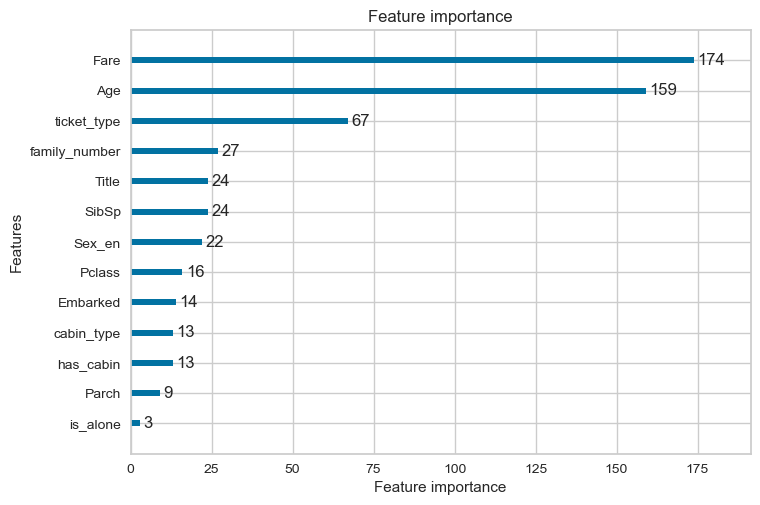

In [64]:
from lightgbm import plot_importance

plot_importance(final_model)

## SHAP Value

In [65]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X)

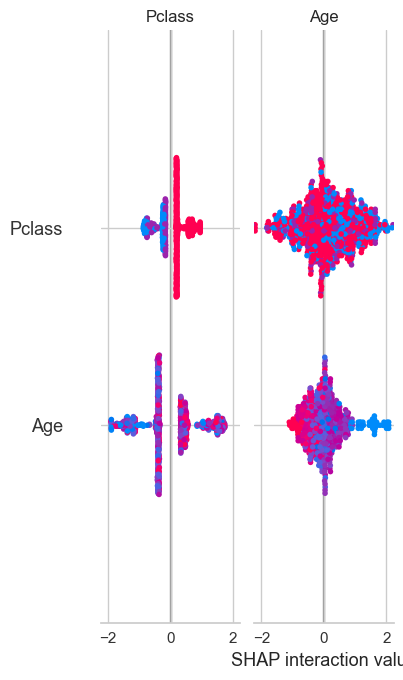

In [66]:
shap.summary_plot(shap_values, X, feature_names=X.columns)

### Pre-process the test data

In [ ]:
X_test = test_df_processed.drop(['PassengerId', 'Ticket', 'Cabin', 'Name', 'Sex'], axis=1)

X_test['Embarked'] = pd.Categorical(X_test['Embarked'])
X_test['Title'] = pd.Categorical(X_test['Title'])
X_test['ticket_type'] = pd.Categorical(X_test['ticket_type'])
X_test['cabin_type'] = pd.Categorical(X_test['cabin_type'])


In [ ]:
# Make prediction using final model
y_pred = final_model.predict(X_test)

In [ ]:
submission_df = pd.DataFrame({'PassengerID': test_df_processed['PassengerId'], 'Survived': y_pred})

In [ ]:
# Create csv for kaggle submission
submission_df.to_csv("submission_titanic.csv", index=False)

# Deployment

- prepare the necessary pickle files of the models including the age imputer and clustering

In [ ]:
import pickle

with open('model/pickles/kmeans.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

with open('model/pickles/final_prediction_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [ ]:
input_dict = {'Pclass': 3,
 'Age': 29.5,
 'SibSp': 0,
 'Parch': 0,
 'Fare': 7.8292,
 'Embarked': 'Q',
 'Cabin': "A35",
 'Title': 'Mrdw',
 'Sex': 'female',
 'Ticket': "330911"
}

In [ ]:
def kmeans_predict(df):
    feature_list = ['Sex_en', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'has_cabin']
    return kmeans.predict(df[feature_list].values)


def preprocess(input_dict):
    
    if input_dict['Cabin']:
        has_cabin = 1
    else:
        has_cabin = 0
    if input_dict['Sex'] == 'male':
        Sex_en = 0
    else:
        Sex_en = 1

    if input_dict['Title'] not in ['Mr', 'Miss', 'Mrs', 'Master']:
        title = "Other"
    else:
        title = input_dict['Title']

    df = pd.DataFrame({
        'Pclass': [input_dict['Pclass']],
        'Age': [input_dict['Age']],
        'SibSp':  [input_dict['SibSp']],
        'Parch':  [input_dict['Parch']],
        'Fare':  [input_dict['Fare']],
        'Embarked':  [input_dict['Embarked']],
        'has_cabin':  [has_cabin],
        'Title':  [title],
        'Sex_en':  [Sex_en],
        'Cabin': [input_dict['Cabin']],
        'Ticket':[input_dict['Ticket']]
        
    })

    df['family_number'] = df.eval("SibSp + Parch")
    df['is_alone'] = df.eval("family_number < 1")
    df['cabin_type'] = pd.Categorical(df.Cabin.fillna("-").apply(lambda x: x[0]))
    df['ticket_type'] = pd.Categorical(df.Ticket.apply(lambda x: x[:3]))
    df['kmeans_label'] = kmeans_predict(df)
    df['Embarked'] = pd.Categorical(df['Embarked'])
    df['Title'] = pd.Categorical(df['Title'])

    df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

    return df


In [ ]:
final_model.predict(preprocess(input_dict))

array([1], dtype=int64)